# **MECS6616 Spring 2025 - Project 3**

# **Introduction**

***IMPORTANT:***
- **Before starting, make sure to read the [Assignment Instructions](https://courseworks2.columbia.edu/courses/215046/pages/assignment-instructions) page on Courseworks to understand the workflow and submission requirements for this project.**

**FOR PROJECT 3!!!**
- Apart from the link to your notebook, you are also required to submit your collected data `.pkl` files and your chosen model checkpoint `.pth` files to Coursework. You will have two files each for parts 2 and 3 for a total of 4 files.
- Your part 2 files should be named `data_pt2.pkl` and `dynamics_pt2.pth`.
- Your part 3 files should be named `data_pt3.pkl` and `dynamics_pt3.pth`.
- You should put the link to your notebook in the "Comment" section of your submission.

## **Project Setup (do NOT change)**

***IMPORTANT:***
- Do NOT change this "*Project Setup*" section
- Do NOT install any other dependencies or a different version of an already provided package. You may, however, import other packages


In [ ]:
# DO NOT CHANGE

# After running this cell, the folder 'mecs6616_sp25_project3' will show up in the file explorer on the left (click on the folder icon if it's not open)
# It may take a few seconds to appear
!git clone https://github.com/roamlab/mecs6616_sp25_project3.git

fatal: destination path 'mecs6616_sp25_project3' already exists and is not an empty directory.


In [ ]:
# DO NOT CHANGE

# move all needed files into the working directory. This is simply to make accessing files easier
!mv /content/mecs6616_sp25_project3/* /content/

mv: cannot stat '/content/mecs6616_sp25_project3/*': No such file or directory


In [ ]:
# Using ray for data collection is optional
!pip install ray

# Starter Code Explanation

This project uses a simulated robot provided by the `Robot` class in `robot.py` file. Each robot is initialized with a corresponding forward dynamics (the base class for forward dynamics definition is in `arm_dynamic_base.py`). The arm_teacher is initialized with the provided ground truth forward dynamics, as defined in `arm_dynamics_teacher.py`. You are welcome to look in-depth into this file to understand how the ground truth forward dynamics is computed for an arm, given its number of links, link mass, and viscous friction of the environment - this is recommended but not necessary to successfully complete this assignment.

The Robot class inside `robot.py` which provides the interface for controlling the robot arm i.e it provides you with some functions to set/get the state and set the action for the arm and take a step using the `Robot.advance()` method. The state of the arm is a 2n-dimensional vector: n joint positions [rad] + n joint velocities [rad/s] and the action is defined as the n torques (in N-m) applied to n joints respectively.

In addition to `arm_dynamics_teacher.py` which contains the ground truth forward dynamics, you will use `arm_dynamics_student.py`, the student dynamics which internally uses a neural network model.

# Part 1: Implement Model Predictive Control



You will implement this controller by completing the MPC class. Specifically, you will implement the compute_action() method by following the algorithm discussed in the lecture. As with previous projects you are free to implement additional methods as needed or change the initialization if need be. While scoring your controller, you will be creating an instance of the MPC class and passing it to the scoring function so ensure that the arguments to the compute_action method remain the same.

Although you do not need to understand how the ArmDynamicsTeacher class works, you could use the compute_fk() method from the class. This will allow you to convert from the state value (represented as array of shape (2*n, 1) where n is num_links) to final end effector position (x, y position of the end effector). Similary we can also compute the velocity of the end effector with the code below:
```
pos_ee = dynamics.compute_fk(state)
vel_ee = dynamics.compute_vel_ee(state)
```


In [ ]:
from itertools import product
import numpy as np

class MPC:
    def __init__(self):
        self.control_horizon = 10
        self.num_trials = 200
        #self.base_plan_horizon = 25

    def compute_action(self, dynamics, state, goal, prev_action):
        num_links = dynamics.get_action_dim()

        # Adaptive planning horizon
        if num_links == 3:
            self.plan_horizon = 30
        elif num_links == 2:
            self.plan_horizon = 20
        else:
            self.plan_horizon = 15

        best_cost = float('inf')
        best_action = np.zeros((num_links, 1))

        for _ in range(self.num_trials):
            # Sample around prev_action
            action = prev_action + np.random.normal(0, 1.0, size=(num_links, 1))
            sim_state = state.copy()
            total_cost = 0

            for t in range(self.plan_horizon):
                sim_state = dynamics.advance(sim_state, action)
                pos = dynamics.compute_fk(sim_state)
                vel = dynamics.compute_vel_ee(sim_state)

                dist_cost = np.linalg.norm(goal - pos)
                vel_cost = np.linalg.norm(vel)
                action_cost = np.linalg.norm(action)

                total_cost += 2.0 * dist_cost + 0.1 * vel_cost + 0.01 * action_cost

                # Penalize final velocity at last step
                if t == self.plan_horizon - 1:
                    total_cost += 1.0 * vel_cost + 1.0 * dist_cost

            if total_cost < best_cost:
                best_cost = total_cost
                best_action = action

        return best_action

## Manually testing the controller
This part is for you to manually check the performance of your controller before you are ready for it be evaluated by our scoring function.
To test your implementation run the following code. Feel free to play around with the cell or change the num_links / goal positions . You can define your controller however you would like to and then switch on gui to see how close your end effectors get to the goal position

Every time step within the environment is 0.01s, which is defined in the dynamics as `dt`.

The MPC class has a `control_horizon` variable which represents the frequency at which `controller.compute_action()` will be called

In the scoring function you will be evaluated on the distance of your end effector to the goal position and the velocity of the end effector.

In [ ]:
import sys
import numpy as np
from arm_dynamics_teacher import ArmDynamicsTeacher
from robot import Robot
from render import Renderer
from score import *
import torch
import time
import math
np.set_printoptions(suppress=True)

# Teacher arm with 3 links
dynamics_teacher = ArmDynamicsTeacher(
    num_links=3,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)
arm = Robot(dynamics_teacher)
arm.reset()

gui = False

if gui:
  renderer = Renderer()
  time.sleep(1)

# Controller
controller = MPC()

# Resetting the arm will set its state so that it is in the vertical position,
# and set the action to be zeros
arm.reset()

# Choose the goal position you would like to see the performance of your controller
goal = np.zeros((2, 1))
goal[0, 0] = 2.5
goal[1, 0] = -0.7
arm.goal = goal

dt = 0.01
time_limit = 2.5
num_steps = round(time_limit/dt)
action = np.zeros((arm.dynamics.get_action_dim(), 1))
# Control loop
for s in range(num_steps):
  t = time.time()
  arm.advance()

  if gui:
    renderer.plot([(arm, "tab:blue")])
  time.sleep(max(0, dt - (time.time() - t)))

  if s % controller.control_horizon==0:
    state = arm.get_state()

    # Measuring distance and velocity of end effector
    pos_ee = dynamics_teacher.compute_fk(state)
    dist = np.linalg.norm(goal-pos_ee)
    vel_ee = np.linalg.norm(arm.dynamics.compute_vel_ee(state))
    print(f'At timestep {s}: Distance to goal: {dist}, Velocity of end effector: {vel_ee}')

    action = controller.compute_action(arm.dynamics, state, goal, action)
    arm.set_action(action)

At timestep 0: Distance to goal: 3.3970575502926055, Velocity of end effector: 5.539171676143414e-18
At timestep 10: Distance to goal: 3.0221236621125294, Velocity of end effector: 3.1678381223727095
At timestep 20: Distance to goal: 2.4841241977210946, Velocity of end effector: 1.1579923879948784
At timestep 30: Distance to goal: 2.096048120169606, Velocity of end effector: 2.844283701628579
At timestep 40: Distance to goal: 1.803309780922466, Velocity of end effector: 2.953987131181743
At timestep 50: Distance to goal: 1.474191263620776, Velocity of end effector: 3.7441090370888332
At timestep 60: Distance to goal: 1.0366990891633898, Velocity of end effector: 5.049281345995622
At timestep 70: Distance to goal: 0.49838068645665823, Velocity of end effector: 5.734491737362981
At timestep 80: Distance to goal: 0.05333320180285915, Velocity of end effector: 4.614804400650513
At timestep 90: Distance to goal: 0.2379628425124543, Velocity of end effector: 3.29528096138034
At timestep 100:

## Grading and Evaluation for Part 1
Your controller will be graded on 6 tests. 2 tests each for the 1-link ,2-link, and 3-link arms. The arm will start off in the initial state with the arms pointing stright down. The testing criteria depend on the distance and the velocity of the end effectors . Each test will run the robot arm for **5.0 seconds**. At the end of the 5 seconds the test will be:

A success if your end effectors meet this criteria:
`distance_to_goal < 0.1 and vel_ee < 0.5`

A partial success if your end effectors meet this criteria:
`distance_to_goal < 0.2 and vel_ee < 0.5`

After all of the tests, your score is summed up and then scaled out of 5 points.


In [ ]:
# Scoring using score_mpc
controller = MPC()
gui = False

In [ ]:
# DO NOT CHANGE
score_mpc_true_dynamics(controller, gui)


Part1: EVALUATING CONTROLLER (with perfect dynamics)
-----------------------------------------------------
NUM_LINKS: 1
Test  1
Success! :)
 Goal: [ 0.38941834 -0.92106099], Final position: [ 0.39052103 -0.92059401], Final velocity: [0.]
score: 1.5/1.5
Test  2
Success! :)
 Goal: [-0.68163876 -0.73168887], Final position: [-0.68121395 -0.73208439], Final velocity: [0.]
score: 1.0/1.0
NUM_LINKS: 2
Test  1
Success! :)
 Goal: [ 0.6814821  -1.61185674], Final position: [ 0.70021544 -1.62701302], Final velocity: [0.03236873]
score: 1.5/1.5
Test  2
Partial Success:|
 Goal: [-1.19286783 -1.28045552], Final position: [-1.05247165 -1.22199274], Final velocity: [0.03171462]
score: 0.5/1.0
NUM_LINKS: 3
Test  1
Success! :)
 Goal: [ 1.29444895 -2.36947292], Final position: [ 1.25429746 -2.36671966], Final velocity: [0.06970063]
score: 1.5/1.5
Test  2
Success! :)
 Goal: [-2.10367746 -1.35075576], Final position: [-2.09744561 -1.33154131], Final velocity: [0.08784864]
score: 1.0/1.0
       
---------

# Part 2: Learning Forward Dynamics

### Background Information

From here on, you will only be working with a 2-link arm.

In part 2, you will be training a model that learns the ground truth dynamics of a 2-link arm. This part uses two 2-link arms, one called arm_teacher (blue) and the other called arm_student (red), as shown in the image below. For each test, a torque will be applied to the first joint of both arms for 5 seconds. arm_teacher is moving according to the provided ground truth forward dynamics and your job is to use deep learning to train the arm_student to learn the forward dynamics of arm_teacher so that it can imitate its behavior. The forward dynamics is a function that takes in the current state of an action applied to the arm, and then computes the new state of the arm. This part uses a time step of 0.01 second, meaning each time we advance the simulation, we compute the forward dynamics for 0.01 second. In the example image, the student arm is not updating its state and remains static but we will make it move after training is done.

<div>
<img src="https://github.com/roamlab/mecs6616_sp25_project3/blob/main/imgs/example.png?raw=true" width="600"/>
</div>

The state of each arm is defined with a (4,1)-dimensional numpy array (two joint positions in radians + two joint velocities in radians per second). An action is defined as the two torques (in Nm) applied to the two joints respectively, which is a (2,1) numpy array. **Throughout this part, we make the problem simpler by only applying a torque to the first joint, so the actions always look like `[torque,0]`.** Also, when scoring your model the robot will always start off in a hanging position, meaning an initial state of `[-pi/2,0,0,0]` so if the collected data from part 2.1 looks similar, the model will perform better. The `robot.py` file provides you with some functions to set/get the state and set the action for the arm. Make sure you understand `robot.py` well enough before getting started.

`geometry.py` provides some geometry functions, `render.py` defines how the visualization is rendered, `custom_plot.py` provides data visualization functionality. These three files are not of particular interest for completing this part.

## Part 2.1: Collecting Data

You will first need to complete the cell below to collect a dataset for training the forward dynamics. After running the cell, it should generate a pickle file `data_pt2.pkl` that contains a data dictionary `data = {'X': X, 'Y': Y}`. The shape of `data['X']` should be (`num_samples`, 6), the first 4 elements are state and the last 2 elements are the action. The shape of `data['Y']` should be (`num_samples`, 4), which saves the next state after applying the action using the ground truth forward dynamics of arm_teacher. You are responsible for deciding and collecting an appropriate amount of samples. Thus, num_samples is entirely up to you and your model.

**After the data file is generated, `data_pt2.pkl` should appear under the 'Files' icon in the left sidebar. You can download this file by right clicking the file name. You are required to submit this file. Please do not change its name.**

In the cell below, we have provided a minimal example of simulating the arm_teacher for 5 seconds. The GUI visualization is turned on and you should see the behavior of arm_teacher. The visualization can drastically slow down the simulator and you should turn it off when collecting a large amount of data.

In [ ]:
import numpy as np
import os
import pickle
import math
from arm_dynamics_teacher import ArmDynamicsTeacher
from robot import Robot

# Set random seed for reproducibility
np.random.seed(42)

# === CONFIG ===
total_steps = 1_000_000
reset_every = 500
dt = 0.01

# Initialize arm
dynamics_teacher = ArmDynamicsTeacher(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=dt
)
arm_teacher = Robot(dynamics_teacher)

# Preallocate memory
state_dim = dynamics_teacher.get_state_dim()
action_dim = dynamics_teacher.get_action_dim()
X = np.zeros((total_steps, state_dim + action_dim), dtype=np.float32)
Y = np.zeros((total_steps, state_dim), dtype=np.float32)

# --- Main Collection Loop ---
for i in range(total_steps):
    if i % reset_every == 0:
        # Reset near hanging pose
        initial_state = np.zeros((state_dim, 1))
        initial_state[0] = -np.pi / 2 + np.random.uniform(-0.05, 0.05)  # small angle offset
        initial_state[1] = np.random.uniform(-0.05, 0.05)
        initial_state[2:] = np.random.uniform(-0.1, 0.1, size=(2, 1))  # low velocity
        arm_teacher.set_state(initial_state)

        # Choose a torque pattern type (simulate score variants)
        torque_mode = np.random.choice(["constant", "linear", "two_stage"])
        if torque_mode == "constant":
            torque_1 = np.random.uniform(-1.0, 1.0)
            torque_plan = [torque_1 for _ in range(reset_every)]
        elif torque_mode == "linear":
            target = np.random.uniform(0.5, 1.0)
            torque_plan = [t / reset_every * target for t in range(reset_every)]
        elif torque_mode == "two_stage":
            torque_1 = np.random.uniform(-1.0, 1.0)
            torque_2 = np.random.uniform(-1.0, 1.0)
            torque_plan = [torque_1 if t < reset_every // 2 else torque_2 for t in range(reset_every)]

    # Apply current torque
    action = np.zeros((action_dim, 1))
    action[0] = torque_plan[i % reset_every]
    arm_teacher.set_action(action)

    # Step and record
    state = arm_teacher.get_state()
    arm_teacher.advance()
    next_state = arm_teacher.get_state()
    delta = next_state - state

    X[i, :] = np.concatenate((state, action), axis=0).flatten()
    Y[i, :] = delta.flatten()

    if i % 10000 == 0:
        print(f"Collected {i}/{total_steps} samples...")

# Save data
data = {'X': X, 'Y': Y}
with open("data_pt2.pkl", "wb") as f:
    pickle.dump(data, f)

print("✅ Data saved to data_pt2.pkl")

Collected 0/1000000 samples...
Collected 10000/1000000 samples...
Collected 20000/1000000 samples...
Collected 30000/1000000 samples...
Collected 40000/1000000 samples...
Collected 50000/1000000 samples...
Collected 60000/1000000 samples...
Collected 70000/1000000 samples...
Collected 80000/1000000 samples...
Collected 90000/1000000 samples...
Collected 100000/1000000 samples...
Collected 110000/1000000 samples...
Collected 120000/1000000 samples...
Collected 130000/1000000 samples...
Collected 140000/1000000 samples...
Collected 150000/1000000 samples...
Collected 160000/1000000 samples...
Collected 170000/1000000 samples...
Collected 180000/1000000 samples...
Collected 190000/1000000 samples...
Collected 200000/1000000 samples...
Collected 210000/1000000 samples...
Collected 220000/1000000 samples...
Collected 230000/1000000 samples...
Collected 240000/1000000 samples...
Collected 250000/1000000 samples...
Collected 260000/1000000 samples...
Collected 270000/1000000 samples...
Collec

Once you've stored X and Y in data, you may uncomment the cell below to see the distribution of end-effector positions and velocities

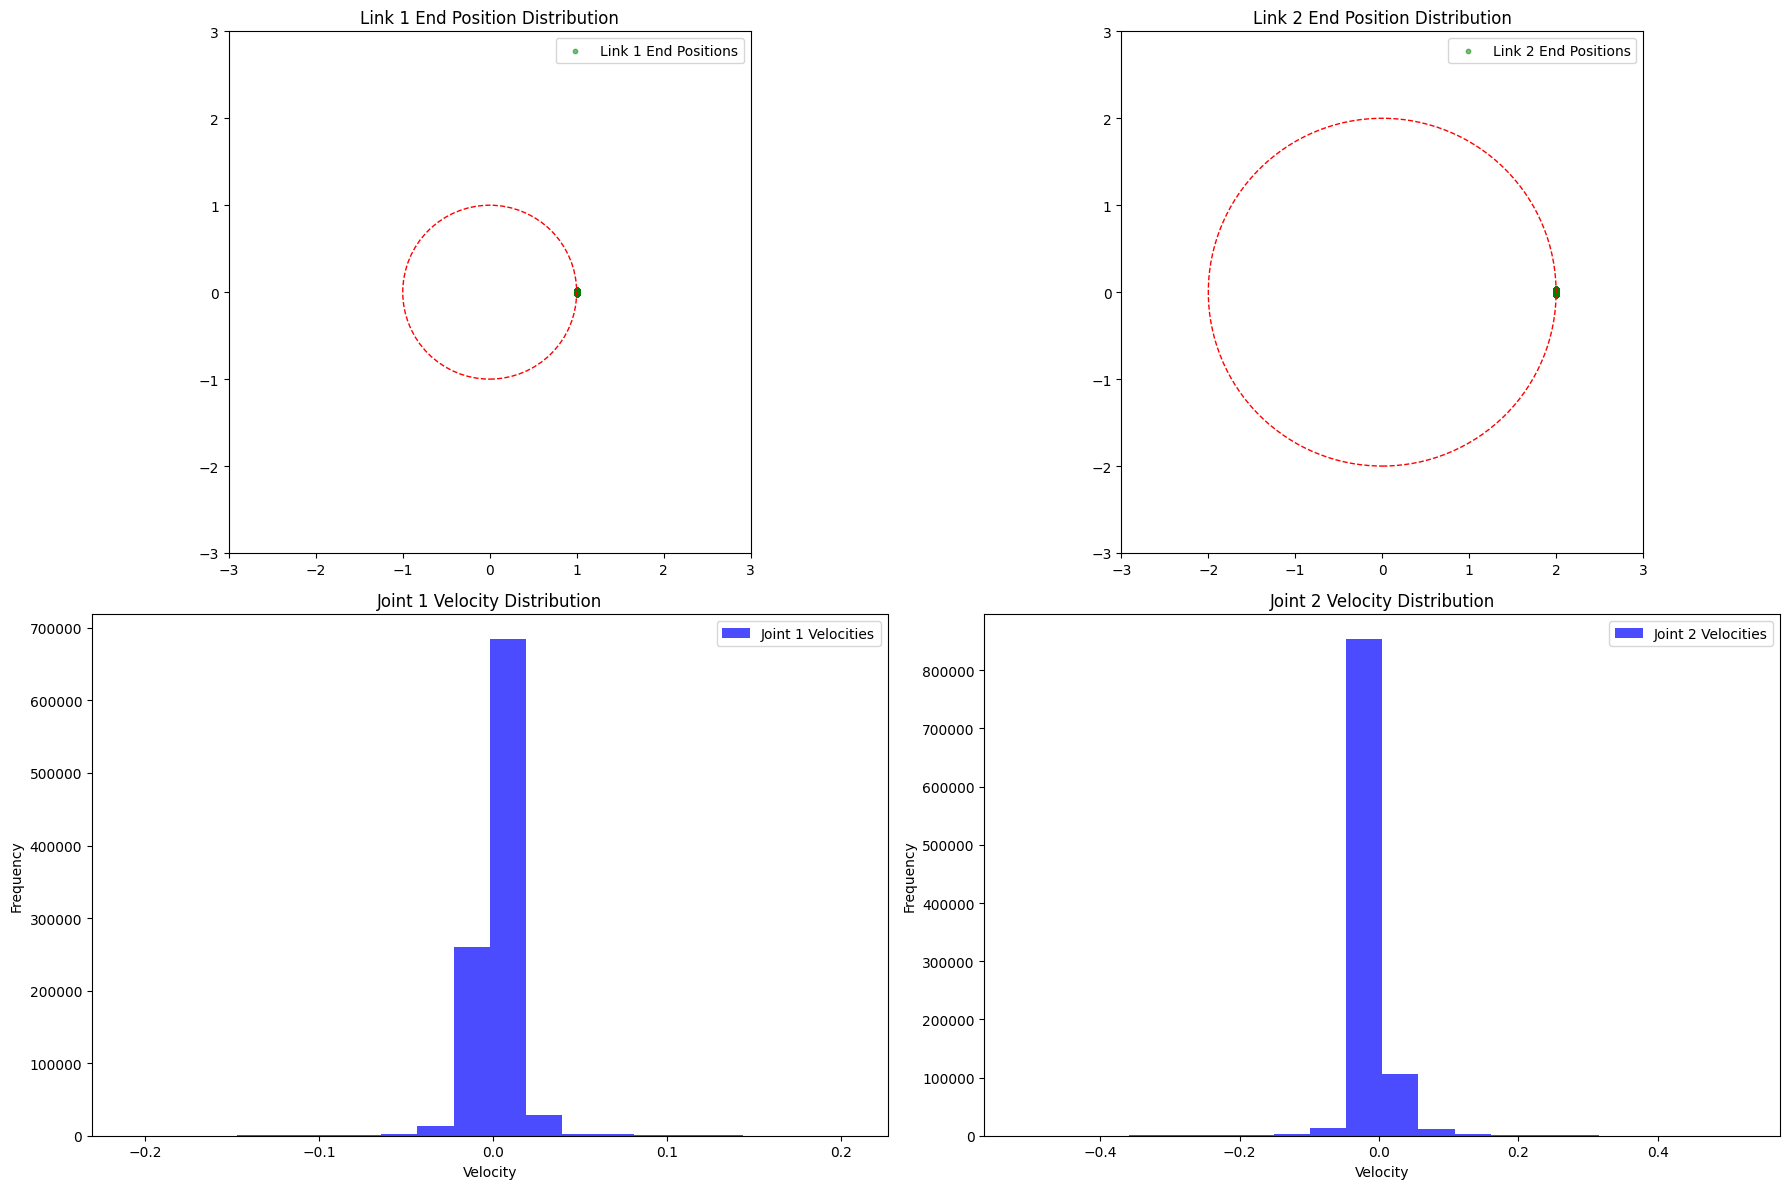

In [ ]:
# Plot the distribution of collected samples
from custom_plot import plot_positions_velocities_with_fixed_bounds
plot_positions_velocities_with_fixed_bounds(data['Y'], [1,1])

## Part 2.2: Learning Forward Dynamics

### Training

After the data is collected, you will then need to complete the cell below to use the collected dataset to learn the forward dynamics.

The code already creates the dataset class and loads the dataset with a random 0.8/0.2 train/test split for you. This cell should save the model that it trains. You should use a specific procedure for saving, outlined below. Note that the saving code is not already included so you will have to add it yourself.

In machine learning, it is a very good practice to save not only the final model but also the checkpoints, such that you have a wider range of models to choose from. We provide a code snippet for you and for each epoch of your training, you should use it to save the model at that epoch.

```
model_folder_name = f'epoch_{epoch:04d}_loss_{test_loss:.8f}'
if not os.path.exists(os.path.join(model_dir, model_folder_name)):
    os.makedirs(os.path.join(model_dir, model_folder_name))
torch.save(model.state_dict(), os.path.join(model_dir, model_folder_name, 'dynamics_pt2.pth'))
```

The output from running this code should be a folder as below:

```
models/
    2025-03-08_23-57-50/
        epoch_0001_loss_0.00032930/
            dynamics_pt2.pth
        epoch_0002_loss_0.00009413/
            dynamics_pt2.pth   
        ...  
```

You can see that every time you run this cell, a folder whose name is the time you started will be created under `models`. Checkpoints from all epochs will be saved and then the folder name for saving the checkpoint indicates the epoch number and loss on the holdout test set. Recording checkpoints this way allows you to easily pick the model with the smallest loss.

### Important: choosing the best model

Your code should keep track of the checkpoint with the smallest loss on the test set. You should save the path of that checkpoint to the variable `model_path`. An example value of `model_path` could be `models/2025-03-07_20-14-32/epoch_0046_loss_0.00000005/dynamics_pt2.pth`. In the evaluation code, the checkpoint from `model_path` will be loaded and evaluated.

You should also download the `dynamics_pt2.pth` file to include in your submission.

A common practice with regards to model saving is to only save models with the best test_loss, rather than checkpoint every epoch. If you want, you can modify the save code to do that instead.

### Model Architecture

In lecture, we introduced the trick to use joint accelerations to compute the next state. You will use your neural network to compute the joint accelerations. This will take in your joint angles, joint velocities, and actions applied to the arm and output joint acceleration values for each link. Then you can use your knowledge of analytical kinematics to derive the joint positions and velocities in the next time step given the joint acceleration values.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
import numpy as np
import torch.nn as nn
import time
import pickle

class DynamicDataset(Dataset):
    def __init__(self, data_file):
        data = pickle.load(open(data_file, "rb"))
        self.X = data['X'].astype(np.float32)  # shape (N, 6)
        self.Y = data['Y'].astype(np.float32)  # shape (N, 4) = delta

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        return self.model(x)


def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for X, Y in loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, Y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
    return total_loss / len(loader.dataset)


def test(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X, Y in loader:
            X, Y = X.to(device), Y.to(device)
            out = model(X)
            loss = criterion(out, Y)
            total_loss += loss.item() * X.size(0)
    return total_loss / len(loader.dataset)


# --- Setup ---
split = 0.2
device = torch.device("cpu")
dataset = DynamicDataset("data_pt2.pkl")
train_size = int(len(dataset) * (1 - split))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, shuffle=True, batch_size=512)
test_loader = DataLoader(test_set, shuffle=False, batch_size=512)

# Save path
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
model_dir = os.path.join("models", timestr)
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "dynamics_pt2.pth")

# Train
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

best_loss = float("inf")
epochs = 50

for epoch in range(1, 1 + epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss = test(model, test_loader, criterion)

    print(f"Epoch {epoch:2d}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}")
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), model_path)
        print(f"✅ Saved best model at epoch {epoch} with loss {test_loss:.6f}")

print(f"\n📁 Best model saved to: {model_path}")

Epoch  1: Train Loss = 0.000028, Test Loss = 0.000002
✅ Saved best model at epoch 1 with loss 0.000002
Epoch  2: Train Loss = 0.000002, Test Loss = 0.000004
Epoch  3: Train Loss = 0.000001, Test Loss = 0.000001
✅ Saved best model at epoch 3 with loss 0.000001
Epoch  4: Train Loss = 0.000001, Test Loss = 0.000001
Epoch  5: Train Loss = 0.000001, Test Loss = 0.000000
✅ Saved best model at epoch 5 with loss 0.000000
Epoch  6: Train Loss = 0.000001, Test Loss = 0.000001
Epoch  7: Train Loss = 0.000001, Test Loss = 0.000000
✅ Saved best model at epoch 7 with loss 0.000000
Epoch  8: Train Loss = 0.000001, Test Loss = 0.000001
Epoch  9: Train Loss = 0.000000, Test Loss = 0.000001
Epoch 10: Train Loss = 0.000000, Test Loss = 0.000001
Epoch 11: Train Loss = 0.000000, Test Loss = 0.000001
Epoch 12: Train Loss = 0.000000, Test Loss = 0.000000
Epoch 13: Train Loss = 0.000000, Test Loss = 0.000000
✅ Saved best model at epoch 13 with loss 0.000000
Epoch 14: Train Loss = 0.000000, Test Loss = 0.00000

## Prediction

After you are done with training, you need to complete the cell below to load the saved checkpoint (in function init_model) and then use it to predict the new state given the current state and action (in function dynamics_step). Please do not modify the arguments to those functions, even though you might not use all of them.

In [ ]:
from arm_dynamics_base import ArmDynamicsBase
import torch
import torch.nn as nn
import numpy as np
import sys
from arm_dynamics_teacher import ArmDynamicsTeacher
from robot import Robot
from render import Renderer
from score import *
import torch
import time
import math
np.set_printoptions(suppress=True)


class ArmDynamicsStudent(ArmDynamicsBase):
    def init_model(self, model_path, num_links, time_step, device):
        self.device = device
        self.model = Net().to(self.device)
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        self.model_loaded = True

    def dynamics_step(self, state, action, dt):
        if self.model_loaded:
            x = np.concatenate([state, action], axis=0).flatten()  # (6,)
            x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(self.device)
            with torch.no_grad():
                delta = self.model(x_tensor).cpu().numpy().reshape(4, 1)
                next_state = state + delta
            return next_state
        else:
            return state

## Evaluation and Grading

The total number of points for this part is 5. There are 3 types of tests. Your grade for this part will be the average score across each type of test

**For each type, there are 50 tests.** For each test, you get a score of 1, 0.5, or 0. Your final grade for each type is the averaged score across 50 tests * 5.

- *Type 1*: for each test, a constant torque randomly sampled from [-1.5Nm, 1.5Nm] is applied to the first joint of the arm for 5 seconds. If the MSE (Mean Squred Error) between the predicted arm state (arm_student) and the ground truth arm state (arm_teacher) is < 0.0005, you get score 1 for this test. If 0.0005 <= MSE < 0.008, you get score 0.5 for this test. Otherwise you get 0.
- *Type 2*: for each test, a torque that linearly increases from 0 to a random torque in [0.5Nm, 1.5Nm] is applied to the first joint of the arm for 5 seconds. If MSE < 0.0005, you get score 1 for this test. If 0.0005 <= MSE < 0.008, you get score 0.5 for this test. Otherwise you get 0.
- *Type 3*: for each test, one torque is applied for the first 2.5 seconds and another torque is applied for the remaining 2.5 seconds. Both torques are sampled from [-1Nm, 1Nm]. If MSE < 0.015, you get score 1 for this test. If 0.015 <= MSE < 0.05, you get score 0.5 for this test. Otherwise you get 0.


In [ ]:
# DO NOT CHANGE
# Set up grading


import importlib
import score
importlib.reload(score)

# Make sure model_path is correctly set
print(model_path)

# Create the teacher arm
dynamics_teacher = ArmDynamicsTeacher(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01
)
arm_teacher = Robot(dynamics_teacher)

# Create the student arm
dynamics_student = ArmDynamicsStudent(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01
)
if model_path is not None:
  dynamics_student.init_model(model_path, num_links=2, time_step=0.01, device=torch.device('cpu'))
arm_student = Robot(dynamics_student)

models/2025-04-02_01-04-29/dynamics_pt2.pth


In [ ]:
# DO NOT CHANGE

# Test on randomly sampled torques from [-1.5, 1.5]
score.score_random_torque(arm_teacher, arm_student, gui=False)


----------------------------------------
TEST 1 (Torque = 0.542641286533492 Nm)

average mse: 2.9473542901151427e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 2 (Torque = -0.958496101281197 Nm)

average mse: 0.0001868800858366403
Score: 1/1
----------------------------------------


----------------------------------------
TEST 3 (Torque = 0.26729646985255084 Nm)

average mse: 1.5195131166940166e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 4 (Torque = 0.4976077650772237 Nm)

average mse: 3.108928844810357e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 5 (Torque = -0.0029859753948191514 Nm)

average mse: 5.940795126649989e-06
Score: 1/1
----------------------------------------


----------------------------------------
TEST 6 (Torque = -0.5504067089383047 Nm)

average mse: 4.312754836090255e-05
Score: 1/1
---------

In [ ]:
# DO NOT CHANGE

# Test on torques that linearly increase from 0 to a random number from [0.5, 1.5]
score.score_linear_torques(arm_teacher, arm_student, gui=False)


----------------------------------------
TEST 1 (Torque 0 -> 0.8856603216333729 Nm)

average mse: 1.6268491476470345e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 2 (Torque 0 -> 0.5103759746797008 Nm)

average mse: 1.372409905768457e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 3 (Torque 0 -> 0.8168241174631377 Nm)

average mse: 1.6355869172762248e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 4 (Torque 0 -> 0.8744019412693059 Nm)

average mse: 1.6237453426353576e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 5 (Torque 0 -> 0.7492535061512953 Nm)

average mse: 1.6844979088536947e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 6 (Torque 0 -> 0.6123983227654238 Nm)

average mse: 1.7079711210087175e-05
Scor

In [ ]:
# DO NOT CHANGE

# Test on one torque applied to the first 2.5s and another torque applied to the second 2.5s
# Both torques are sampled from [-1, 1]
score.score_two_torques(arm_teacher, arm_student, gui=False)


----------------------------------------
TEST 1 (Torque 1 = 0.542641286533492 Nm,  Torque 2 = -0.21494151210682544 Nm)

average mse: 3.1764600288540314e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 2 (Torque 1 = -0.958496101281197 Nm,  Torque 2 = -0.8130792508826994 Nm)

average mse: 0.00020999278402628003
Score: 1/1
----------------------------------------


----------------------------------------
TEST 3 (Torque 1 = 0.26729646985255084 Nm,  Torque 2 = 0.6422113156738569 Nm)

average mse: 2.409850958268492e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 4 (Torque 1 = 0.4976077650772237 Nm,  Torque 2 = -0.6976959607148723 Nm)

average mse: 5.828568373233792e-05
Score: 1/1
----------------------------------------


----------------------------------------
TEST 5 (Torque 1 = -0.0029859753948191514 Nm,  Torque 2 = -0.23177110261560085 Nm)

average mse: 1.594258579894494e-05
S

# Part 3: MPC Controller with Learned Dynamics Model

## Part 3.1: Model Architecture

We have a base class Model and a subclass for the 2-link arm. The class Model is a base class for our models. In compute_next_state() method, you have to use the trick to use joint accelerations to compute the next state similar to what you did in Part 2.

In the `Model2Link` class you will use a neural network to compute the joint accelerations by implementing `compute_qddot()` method. This will take 6 values (2 joint angles, 2 joint velocities and 2 actions applied to the arm) and output 2 joint acceleration values

Do not change the arguments for the `__init__()` method even if you do not use them.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
	def __init__(self, num_links, time_step):
		super().__init__()
		self.num_links = num_links
		self.time_step = time_step

	def forward(self, x):
		qddot = self.compute_qddot(x)
		state = x[:, :2*self.num_links]
		next_state = self.compute_next_state(state, qddot)
		return next_state

	def compute_next_state(self, state, qddot):

		dt = self.time_step
		q = state[:, :2]
		q_dot = state[:, 2:]

		q_dot_next = q_dot + qddot * dt
		q_next = q + q_dot * dt + 0.5 * qddot * (dt ** 2)
		next_state = torch.cat([q_next, q_dot_next], dim=1)
		return next_state

	def compute_qddot(self, x):
		raise NotImplementedError("Subclasses must implement compute_qddot")

class Model2Link(Model):
  def __init__(self, time_step):
    super().__init__(num_links=2, time_step=time_step)

    self.model = nn.Sequential(
            nn.Linear(6, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
    				nn.ReLU(),
            nn.Linear(64, 2)
    )
  def compute_qddot(self, x):
    return self.model(x)

## Part 3.2: Collect Data
Similar to part 2, we will collect data which will be used to learn a forward model for our 2 link robot arm. Once we have learnt a forward model you will be evaluated on your MPC Controller that uses the learnt dynamics model instead of the true dynamics.

You can modify the collect_data function or write any of your own functions however you choose to. You will be evaluated on the **2 Link Robot**

In [ ]:
import sys
import numpy as np
from arm_dynamics_teacher import ArmDynamicsTeacher
from robot import Robot
from render import Renderer
from score import *
import torch
import time
import math
np.set_printoptions(suppress=True)
dynamics_teacher = ArmDynamicsTeacher(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)

arm = Robot(dynamics_teacher)
arm.reset()

def collect_data(arm):
    num_rollouts = 400  # collect more data for better generalization
    steps_per_rollout = 50
    num_samples = num_rollouts * steps_per_rollout

    state_dim = arm.dynamics.get_state_dim()  # 4
    action_dim = arm.dynamics.get_action_dim()  # 2

    X = np.zeros((num_samples, state_dim + action_dim), dtype=np.float32)
    Y = np.zeros((num_samples, state_dim), dtype=np.float32)

    idx = 0
    for rollout in range(num_rollouts):
        # Reset to a diverse but reachable state (not just near hanging)
        q = np.random.uniform(-np.pi, np.pi, size=(2,))
        qdot = np.random.uniform(-1.0, 1.0, size=(2,))
        state = np.concatenate([q, qdot]).reshape(-1, 1)
        arm.set_state(state)

        # 🎯 Random goal similar to score_mpc_learnt_dynamics
        goal = np.random.uniform(low=[0.05, -1.2], high=[1.95, 0.0]).reshape(2, 1)

        # Direction toward goal
        ee_pos = arm.dynamics.compute_fk(state)
        delta = goal - ee_pos
        unit_direction = delta / (np.linalg.norm(delta) + 1e-6)

        # Torque plan to roughly go toward goal
        torque_magnitude = np.random.uniform(0.5, 1.5)
        torque_direction = np.clip(unit_direction, -1, 1)
        base_torque = torque_magnitude * torque_direction.flatten()

        noise_level = 0.3

        for s in range(steps_per_rollout):
            # Add small randomness to simulate diverse interactions
            torque = base_torque + np.random.normal(0, noise_level, size=(2,))
            torque = np.clip(torque, -2.0, 2.0)
            action = torque.reshape(-1, 1)

            arm.set_action(action)
            state = arm.get_state()
            arm.advance()
            next_state = arm.get_state()

            X[idx, :] = np.concatenate([state, action], axis=0).flatten()
            Y[idx, :] = next_state.flatten()
            idx += 1

    return X, Y

In [ ]:
import pickle

# Call the function you have defined above to collect data
X, Y = collect_data(arm)
save_dir = 'dataset'
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

# Save the collected data in the data_pt3.pkl file
data = {'X': X, 'Y': Y}
pickle.dump(data, open(os.path.join(save_dir, 'data_pt3.pkl'), "wb" ))

## Part 3.3: Training the forward model
By now you would be familiar with the basic skeleton of training a forward model.

The starter code already creates the dataset class and loads the dataset with a random 0.8/0.2 train/test split for you. This script should save the model that it trains. You should use a specific procedure for saving, outlined below.

In machine learning, it is a very good practice to save not only the final model but also the checkpoints. Our starter code already configures save_dir for you and for each epoch of your training, you should use the following code to save the model at that epoch.

```
model_folder_name = f'epoch_{epoch:04d}_loss_{test_loss:.8f}'
if not os.path.exists(os.path.join(args.save_dir, model_folder_name)):
    os.makedirs(os.path.join(args.save_dir, model_folder_name))
torch.save(model.state_dict(), os.path.join(args.save_dir, model_folder_name, 'dynamics_pt3.pth'))
print(f'model saved to {os.path.join(args.save_dir, model_folder_name, "dynamics_pt3.pth")}\n')
```
The output from running this code should be a folder as below:

```
models/
    2021-03-24_23-57-50/
        epoch_0001_loss_0.00032930/
            dynamics_pt3.pth
        epoch_0002_loss_0.00009413/
            dynamics_pt3.pth   
        ...  
```
You can implement the functions below as you please to collect data

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import pickle
import torch.optim as optim
import time

class DynamicDataset(Dataset):
    def __init__(self, datafile):
        data = pickle.load(open(datafile, 'rb'))
        self.X = data['X'].astype(np.float32)
        self.Y = data['Y'].astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for X, Y in loader:
        optimizer.zero_grad()
        X = X.to(device)
        Y = Y.to(device)
        pred_Y = model(X)
        loss = criterion(pred_Y, Y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
    return total_loss / len(loader.dataset)

def test(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X, Y in loader:
            X = X.to(device)
            Y = Y.to(device)
            pred_Y = model(X)
            loss = criterion(pred_Y, Y)
            total_loss += loss.item() * X.size(0)
    return total_loss / len(loader.dataset)

def train_forward_model():
    model_path = None
    min_test_loss = float('inf')
    model = Model2Link(time_step=0.01).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.MSELoss()

    datafile = 'dataset/data_pt3.pkl'
    split = 0.2
    dataset = DynamicDataset(datafile)
    dataset_size = len(dataset)
    test_size = int(np.floor(split * dataset_size))
    train_size = dataset_size - test_size
    train_set, test_set = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

    # Make save dir
    timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
    model_dir = os.path.join('models', timestr)
    os.makedirs(model_dir, exist_ok=True)

    epochs = 200
    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        test_loss = test(model, test_loader, criterion)

        print(f"[Epoch {epoch}] Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")

        # Save checkpoint
        checkpoint_path = os.path.join(model_dir, f'epoch_{epoch}.pth')
        torch.save(model.state_dict(), checkpoint_path)

        if test_loss < min_test_loss:
            min_test_loss = test_loss
            model_path = os.path.join(model_dir, 'best_model.pth')
            torch.save(model.state_dict(), model_path)
            print(f"✅ Best model saved at epoch {epoch} with test loss {test_loss:.6f}")

    return model_path,model

# Set CPU only
device = torch.device("cpu")

# Train and get final model path
model_path, model = train_forward_model()
print(f"\n📦 Final saved model: {model_path}")

[Epoch 1] Train Loss: 0.043860 | Test Loss: 0.042448
✅ Best model saved at epoch 1 with test loss 0.042448
[Epoch 2] Train Loss: 0.036710 | Test Loss: 0.035329
✅ Best model saved at epoch 2 with test loss 0.035329
[Epoch 3] Train Loss: 0.030157 | Test Loss: 0.030563
✅ Best model saved at epoch 3 with test loss 0.030563
[Epoch 4] Train Loss: 0.025636 | Test Loss: 0.026462
✅ Best model saved at epoch 4 with test loss 0.026462
[Epoch 5] Train Loss: 0.021422 | Test Loss: 0.022534
✅ Best model saved at epoch 5 with test loss 0.022534
[Epoch 6] Train Loss: 0.018252 | Test Loss: 0.020670
✅ Best model saved at epoch 6 with test loss 0.020670
[Epoch 7] Train Loss: 0.015952 | Test Loss: 0.017827
✅ Best model saved at epoch 7 with test loss 0.017827
[Epoch 8] Train Loss: 0.014185 | Test Loss: 0.016468
✅ Best model saved at epoch 8 with test loss 0.016468
[Epoch 9] Train Loss: 0.013221 | Test Loss: 0.014929
✅ Best model saved at epoch 9 with test loss 0.014929
[Epoch 10] Train Loss: 0.012396 | Tes

In [ ]:
torch.save(model.state_dict(), "dynamics_pt3.pth")

## Part 3.4: Completing ArmDynamicsStudent

After you are done with training, you need to complete ArmDynamicsStudent class following the comments below to load the saved checkpoint (in function init_model) and then use it to predict the new state given the current state and action (in function dynamics_step). Please do not modify the arguments to those functions, even though you might not use all of them.

In [ ]:
import torch
import numpy as np
from arm_dynamics_base import ArmDynamicsBase

class ArmDynamicsStudent(ArmDynamicsBase):
    def init_model(self, model_path, num_links, time_step, device):
        # Load model and set to eval mode
        self.device = device
        self.model = Model2Link(time_step=time_step).to(self.device)
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        self.model_loaded = True

    def dynamics_step(self, state, action, dt):
        if self.model_loaded:
            # Prepare input: shape (1, 6)
            x = np.concatenate((state, action), axis=0).astype(np.float32).reshape(1, -1)
            x_tensor = torch.tensor(x, dtype=torch.float32).to(self.device)

            # Forward pass
            with torch.no_grad():
                next_state = self.model(x_tensor).cpu().numpy().reshape(-1, 1)  # shape (4, 1)

            return next_state
        else:
            return state

## Manually Testing the MPC Controller with the learnt dynamics model
We will now use the learnt dynamics model that you have trained. The model is loaded in the dynamics.init_model method. You can modify the goal positions to see how well is the controller performing similar to what you did before. Feel free to play around with the code in this cell to test your performance before the grading part.


In [ ]:
import sys
import numpy as np
from arm_dynamics_teacher import ArmDynamicsTeacher
from robot import Robot
from render import Renderer
from score import *
import torch
import time

# Teacher arm with 3 links
dynamics_teacher = ArmDynamicsTeacher(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)

arm = Robot(dynamics_teacher)
arm.reset()

gui = False
action = np.zeros((arm.dynamics.get_action_dim(), 1))
if gui:
  renderer = Renderer()
  time.sleep(1)

# Controller
controller = MPC()
dynamics_student = ArmDynamicsStudent(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)
device = torch.device('cpu')

# model_path should have the path to the best model that you have trained so far
# which you would like to use for testing the controller
model_path = None
dynamics_student.init_model(model_path, 2, 0.01, device)

# Control loop
action = np.zeros((arm.dynamics.get_action_dim(), 1))
goal = np.zeros((2, 1))
goal[0, 0] = 2.7
goal[1, 0] = 0.5
arm.goal = goal

dt = 0.01
time_limit = 2.5
num_steps = round(time_limit/dt)
for s in range(num_steps):
  t = time.time()
  arm.advance()

  if gui:
    renderer.plot([(arm, "tab:blue")])
  time.sleep(max(0, dt - (time.time() - t)))

  if s % controller.control_horizon==0:
    state = arm.get_state()
    action = controller.compute_action(dynamics_student, state, goal, action)
    arm.set_action(action)


AttributeError: 'NoneType' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

## Grading and Evaluation of Part 3
You will be evaluated on how well your controller+learnt dynamics works together. The scoring functions consists of 16 random test goals all of which will be below the x axis and between 0.05 to 1.95 lengths away from the origin.
The controller will call the compute_action method from your MPC class and apply the action for 10 timesteps
```
action = controller.compute_action(dynamics_student, state, goal, action)
```

Each test will run the robot arm for **2.5 seconds**. At the end of the 2.5 seconds the test will be:

A success if your end effectors meet this criteria:
`distance_to_goal < 0.2 and vel_ee < 0.5`

A partial success if your end effectors meet this criteria:
`distance_to_goal < 0.3 and vel_ee < 0.5`

After all of the tests are complete, your score is summed up and then scaled out of 5 total points. You need 15 out of the 16 tests to succeed to get a full score.

In [ ]:
class PolarAwareMPC:
    def __init__(self):
        self.control_horizon = 10
        self.num_trials = 200

    def compute_action(self, dynamics, state, goal, prev_action):
        num_links = dynamics.get_action_dim()

        if num_links == 3:
            self.plan_horizon = 30
        elif num_links == 2:
            self.plan_horizon = 25  # longer horizon for more refined motion
        else:
            self.plan_horizon = 15

        best_cost = float('inf')
        best_action = np.zeros((num_links, 1))

        for _ in range(self.num_trials):
            action = prev_action + np.random.normal(0, 0.8, size=(num_links, 1))
            sim_state = state.copy()
            total_cost = 0

            for t in range(self.plan_horizon):
                sim_state = dynamics.advance(sim_state, action)
                pos = dynamics.compute_fk(sim_state)
                vel = dynamics.compute_vel_ee(sim_state)

                dist_cost = np.linalg.norm(goal - pos)
                vel_cost = np.linalg.norm(vel)
                action_cost = np.linalg.norm(action)

                # Polar angle alignment (theta in goal region: [pi, 2pi])
                goal_angle = np.arctan2(goal[1, 0], goal[0, 0])
                pos_angle = np.arctan2(pos[1, 0], pos[0, 0])
                polar_cost = 0.2 * abs(goal_angle - pos_angle)

                total_cost += (
                    2.0 * dist_cost +
                    0.1 * vel_cost +
                    0.01 * action_cost +
                    polar_cost
                )

                if t == self.plan_horizon - 1:
                    total_cost += 2.0 * vel_cost + 1.5 * dist_cost

            if total_cost < best_cost:
                best_cost = total_cost
                best_action = action

        return best_action

In [ ]:
controller = PolarAwareMPC()
dynamics_student = ArmDynamicsStudent(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)
model_path = 'dynamics_pt3.pth'
gui=False

In [ ]:
# DO NOT CHANGE
score_mpc_learnt_dynamics(controller, dynamics_student, model_path, gui)

Part2: EVALUATING CONTROLLER + LEARNED DYNAMICS
-----------------------------------------------
NUM_LINKS: 2
Test  1
Success! :)
 Goal: [ 0.9757701  -0.44276989], Final position: [ 0.87202734 -0.52647378], Final velocity: [0.02037758]
score: 0.5/0.5
Test  2
Success! :)
 Goal: [-0.14215515 -0.17479505], Final position: [-0.11750973 -0.14540357], Final velocity: [0.00880942]
score: 0.5/0.5
Test  3
Success! :)
 Goal: [-0.09044545 -1.46700245], Final position: [-0.07367074 -1.54020788], Final velocity: [0.06279016]
score: 0.5/0.5
Test  4
Fail :(
 Goal: [ 0.17948957 -0.29773989], Final position: [-0.0132307  -0.30562156], Final velocity: [1.01403489]
score: 0/0.5
Test  5
Success! :)
 Goal: [-0.11716756 -0.43225151], Final position: [-0.08154878 -0.39977247], Final velocity: [0.05062997]
score: 0.5/0.5
Test  6
Success! :)
 Goal: [-0.0888479  -0.21302413], Final position: [-0.119196   -0.15569801], Final velocity: [0.07643776]
score: 0.5/0.5
Test  7
Success! :)
 Goal: [ 0.41779827 -1.34062054

Time Limit
*   MPC evaluation (Part 1): 30 minutes
*   Data Collection with MPC (Part 2): 1 hour 20 minutes
*   Training the forward dynamics model (Part 3): 40 minutes

Note: Time limits are general guidelines. While your code must run within the allotted time, you should be able to achieve full score with a much shorter runtime


Hints and Suggestions:
1. You can use your MPC Controller in your data collection to gather better training samples
2. A good cost function to evaluate your trajectory in MPC is very important and you can use both distance and velocity metrics to define the cost function.
3. As mentioned in the lecture, a constant torque with pseudo gradients seems to work well for this project. You can also use multiple delta values to gather more trajectories to choose from.
4. Since we are passing the MPC object to the controller you can instantiate the MPC class with different parameters like the planning horizon, delta values etc.
5. To speed up data collection, avoid using np.concatenate(), np.stack() or np.append() like functions on your X and Y arrays. Instead, initialize X and Y arrays with all zeros using the correct shape and then fill in the values one by one. This is much faster in numpy. Using Ray is optional

# Other Requirements and Hints

Time Limit
*   MPC evaluation (Part 1): 30 minutes
*   Learned Forward Model (Part 2): Less than a hundred epochs of training (<= 25 mins) should suffice for achieving the full points. Again, the shorter your model training time is the better.
*   Data Collection with MPC (Part 3): 1 hour 20 minutes
*   Training the forward dynamics model (Part 3): 40 minutes

Note: Time limits are general guidelines. While your code must run within the allotted time, you should be able to achieve full score with a much shorter runtime


Hints and Suggestions:
1. Choosing the right policy to collect datasets for this project (parts 2 and 3) is important. You need to think about how to do it properly so that your trained model will pass the tests successfully. It is in general very hard to learn the ground truth forward dynamics completely (that works for any distribution of actions), and during testing small errors can accumulate, leading to drastic failure in the end. You might want to try overfitting on the test cases to begin with.
2. Make sure that your dataset for part 2 is less than 100 Mb, which is pretty much sufficient for achieving full marks. Collecting datasets can be time-consuming and you could parallelize this process for some speed-up using [ray](https://www.ray.io/). Make sure your data collection in part 2 takes <= 25 mins.
3. You can use your MPC Controller in your data collection for part 3 to gather better training samples
4. A good cost function to evaluate your trajectory in MPC is very important and you can use both distance and velocity metrics to define the cost function.
5. As mentioned in the lecture, a constant torque with pseudo gradients seems to work well for this project. You can also use multiple delta values to gather more trajectories to choose from.
6. Since we are passing the MPC object to the controller you can instantiate the MPC class with different parameters like the planning horizon, delta values etc.
7. To speed up data collection, avoid using np.concatenate(), np.stack() or np.append() like functions on your X and Y arrays. Instead, initialize X and Y arrays with all zeros using the correct shape and then fill in the values one by one. This is much faster in numpy. Using Ray is optional
8. You may reuse your part 2 model for part 3, but it may be beneficial to re-collect data to train a model specific to part 3.

General Tips and Requirements
- NO GPU: No GPU is required or allowed for this assignment and we will test your code without GPUs.
- Loss Function: This is essentially a regression problem so think about what losses are suitable for regression.
- Optimizer: While it is possible to use a simple optimizer to achieve the desired accuracy, the training time can be quite high. There exists a number of optimizers implemented in PyTorch that have much faster convergence.
- Seeding. Please use seeding in your code to make sure your results are reproducible.